# Performing landscape level predictions

Mount drive, install package


In [1]:
import rasterio
###
site_path = "large_files/"

img_path = site_path + "lhc_om1.tif"
#img_path = site_path + "/rgb/2016/Paracou_RGB_2016_10cm.tif"
tiles_path = site_path + "tileslhc/"
#model_path = "/content/drive/Shareddrives/detectree2/models/220629_ParacouSepilokDanum_JB.pth"

# Read in the tiff file
data = rasterio.open(img_path)

## Tiling
Tile up the entire orthomosaic to make predictions

In [6]:
from detectree2.preprocessing.tiling import tile_data
buffer = 20
tile_width = 10
tile_height = 10
tile_data(img_path, tiles_path, buffer, tile_width, tile_height, dtype_bool = True)

  0%|          | 0/255 [00:00<?, ?it/s]

INFO:detectree2.preprocessing.tiling:Tiling complete


## Create full site predictions

### Access pre-trained model

Download pre-trained model

There might be a cleaner way to do it with `pkg_resources` but I haven't figured this out yet

In [7]:
from detectree2.models.train import MyTrainer, setup_cfg

# pretrained model?
#trained_model = "/content/drive/Shareddrives/detectree2/models/220629_ParacouSepilokDanum_JB.pth"
#trained_model = "/content/drive/Shareddrives/detectree2/models/220723_withParacouUAV.pth"
#trained_model = "/content/drive/Shareddrives/detectree2/models/230103_resize_full/model_4.pth"
# trained_model = "large_files/230103_randresize_full.pth"
trained_model = "large_files/urban_trees_Cambridge_20230630.pth"

cfg = setup_cfg(update_model=trained_model) # update_model arg can be used to load in trained  model

Make predictions!

In [8]:
from detectree2.models.predict import predict_on_data
from detectron2.engine import DefaultPredictor
#cfg.MODEL.DEVICE='cpu'
predict_on_data(directory=tiles_path, predictor=DefaultPredictor(cfg))

INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from large_files/urban_trees_Cambridge_20230630.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from large_files/urban_trees_Cambridge_20230630.pth ...


Predicting 218 files in mode rgb


/home/gaurav/anaconda3/envs/drone-monitoring/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Predicted 50 files of 218
Predicted 100 files of 218
Predicted 150 files of 218
Predicted 200 files of 218


Here we reproject predictions into geographical space

In [9]:
from detectree2.models.outputs import project_to_geojson
project_to_geojson(tiles_path, tiles_path + "predictions/", tiles_path + "predictions_geo/")

Projecting 218 files
Projecting file 50 of 218: large_files/tileslhc/predictions/Prediction_lhc_om1_714506_3159387_10_20_32643.json
Projecting file 100 of 218: large_files/tileslhc/predictions/Prediction_lhc_om1_714536_3159367_10_20_32643.json
Projecting file 150 of 218: large_files/tileslhc/predictions/Prediction_lhc_om1_714496_3159357_10_20_32643.json
Projecting file 200 of 218: large_files/tileslhc/predictions/Prediction_lhc_om1_714626_3159427_10_20_32643.json


Combine predictions into full output

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from detectree2.models.outputs import stitch_crowns, clean_crowns
#name = "Paracou"
folder = tiles_path+ "/predictions_geo"
crowns = stitch_crowns(folder, 1)

Stitching file 50 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714556_3159337_10_20_32643.geojson
Stitching file 100 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714526_3159387_10_20_32643.geojson
Stitching file 150 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714536_3159397_10_20_32643.geojson
Stitching file 200 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714486_3159377_10_20_32643.geojson


Remove invalid geometries before cleaning. Might be a way to fix them rather than remove all together but I think the ones with invalid geometries tend to be bad crowns anyway.

In [11]:
crowns = stitch_crowns(folder, 1)
crowns = crowns[crowns.is_valid]
# Simplify crowns to help with editing
crowns = crowns.set_geometry(crowns.simplify(0.3))
crowns

Stitching file 50 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714556_3159337_10_20_32643.geojson
Stitching file 100 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714526_3159387_10_20_32643.geojson
Stitching file 150 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714536_3159397_10_20_32643.geojson
Stitching file 200 of 218: large_files/tileslhc/predictions_geo/Prediction_lhc_om1_714486_3159377_10_20_32643.geojson


,Confidence_score,geometry
0,0.887501,"POLYGON ((714493.482 3159458.33, 714492.009 31..."
1,0.885529,"POLYGON ((714514.288 3159487.631, 714512.207 3..."
2,0.881802,"POLYGON ((714505.51 3159462.622, 714502.476 31..."
3,0.854078,"POLYGON ((714507.418 3159467.78, 714505.901 31..."
4,0.836167,"POLYGON ((714488.389 3159463.792, 714487.674 3..."
...,...,...
16479,0.090063,"POLYGON ((714499.377 3159437.265, 714498.684 3..."
16480,0.089103,"POLYGON ((714493.027 3159436.094, 714492.42 31..."
16482,0.087414,"POLYGON ((714513.421 3159448.881, 714511.687 3..."
16483,0.082804,"POLYGON ((714498.424 3159424.218, 714497.752 3..."


Clean overlapping crowns. For significant overlaps, the most confident crown is selected. IoU can be varied based on how strict you want the filtering to be.

In [12]:
crowns = clean_crowns(crowns, 0.7, 0.5)

Cleaning 14287 crowns
0 / 14287 crowns cleaned
1000 / 14287 crowns cleaned
2000 / 14287 crowns cleaned
3000 / 14287 crowns cleaned
4000 / 14287 crowns cleaned
5000 / 14287 crowns cleaned
6000 / 14287 crowns cleaned
7000 / 14287 crowns cleaned
8000 / 14287 crowns cleaned
9000 / 14287 crowns cleaned
10000 / 14287 crowns cleaned
11000 / 14287 crowns cleaned
12000 / 14287 crowns cleaned
13000 / 14287 crowns cleaned
14000 / 14287 crowns cleaned


In [ ]:
crowns.to_file("tiles/crowns_map.gpkg")

In [ ]:
!zip tiles.zip -r tiles/

  adding: tiles/ (stored 0%)
  adding: tiles/crowns_map.gpkg (deflated 71%)
  adding: tiles/odm_orthophoto_714284_3159599_45_20_32643.tif (deflated 14%)
  adding: tiles/odm_orthophoto_714374_3159644_45_20_32643.tif (deflated 17%)
  adding: tiles/odm_orthophoto_714374_3159599_45_20_32643.png (deflated 2%)
  adding: tiles/odm_orthophoto_714419_3159644_45_20_32643.png (deflated 2%)
  adding: tiles/odm_orthophoto_714329_3159599_45_20_32643.tif (deflated 14%)
  adding: tiles/odm_orthophoto_714329_3159509_45_20_32643.tif (deflated 13%)
  adding: tiles/odm_orthophoto_714374_3159554_45_20_32643.png (deflated 1%)
  adding: tiles/odm_orthophoto_714329_3159554_45_20_32643.tif (deflated 12%)
  adding: tiles/odm_orthophoto_714419_3159599_45_20_32643.tif (deflated 14%)
  adding: tiles/odm_orthophoto_714374_3159599_45_20_32643.tif (deflated 16%)
  adding: tiles/predictions/ (stored 0%)
  adding: tiles/predictions/Prediction_odm_orthophoto_714374_3159599_45_20_32643.json (deflated 70%)
  adding: tiles

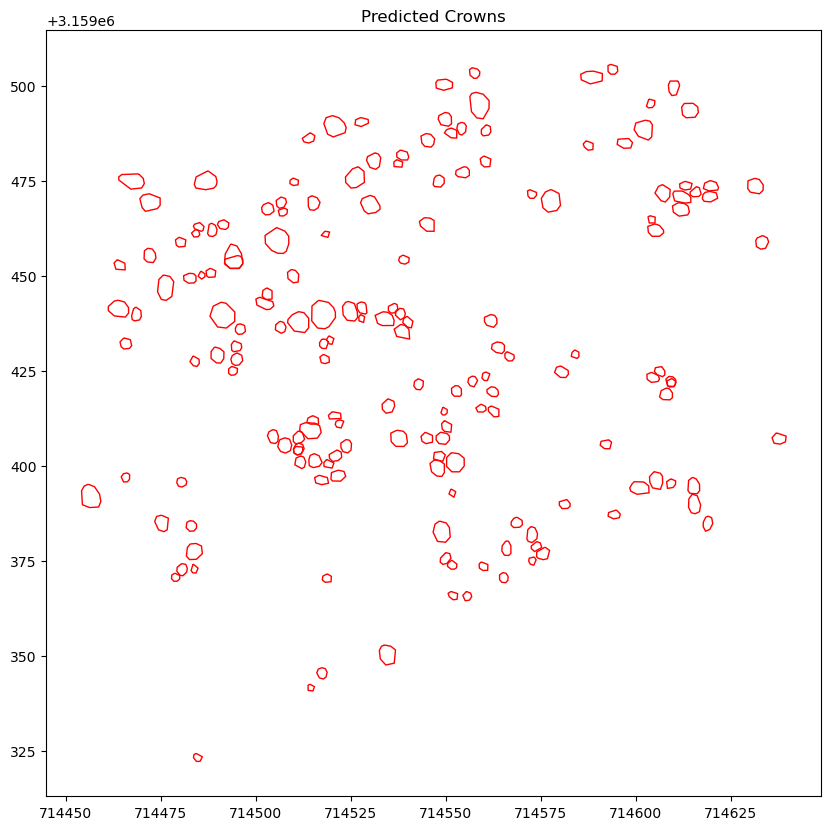

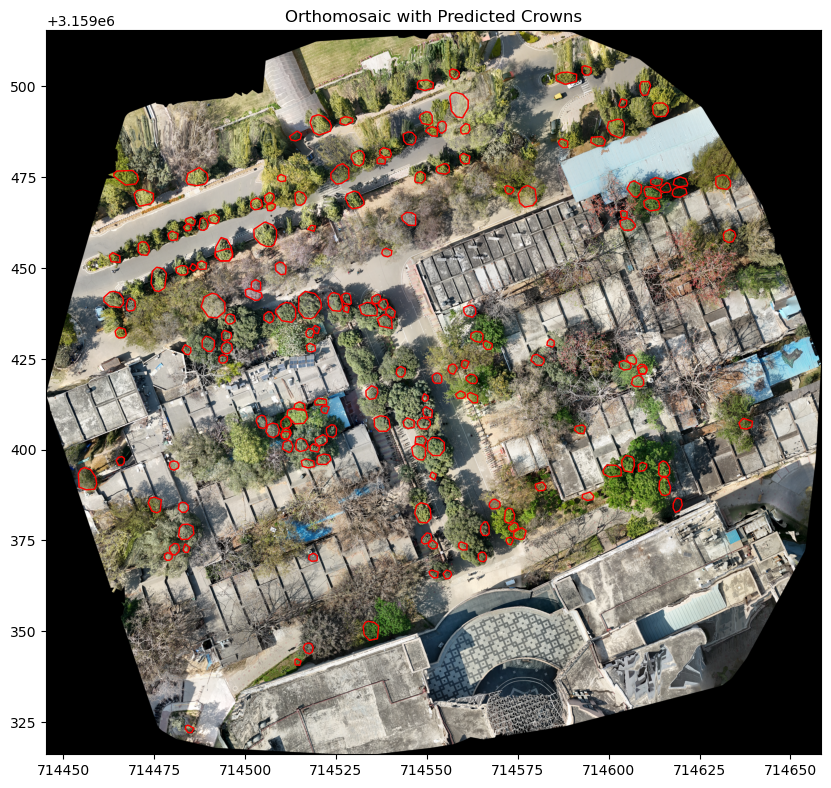

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show

# Assuming crowns is your GeoDataFrame with predicted crown geometries
# If you want to see just the crowns:
fig, ax = plt.subplots(figsize=(10, 10))
crowns.plot(ax=ax, facecolor='none', edgecolor='red')
ax.set_title("Predicted Crowns")
plt.show()

# Alternatively, if you'd like to overlay the crowns on the original image:
# Open the original orthomosaic image using rasterio
img_path = site_path + "lhc_om1.tif"
with rasterio.open(img_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax)
    crowns.plot(ax=ax, facecolor='none', edgecolor='red')
    ax.set_title("Orthomosaic with Predicted Crowns")
    plt.show()
